<a href="https://colab.research.google.com/github/vineeth475/gogreen/blob/master/notebooks/lazy_benefit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
%load_ext fireducks.pandas
import numpy as np
import fireducks.pandas as pd

In [2]:
pip install fireducks

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 61.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 MB 16.3 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 17.0.0
    Uninstalling pyarrow-17.0.0:
      Successfully uninstalled pyarrow-17.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.10.1 requires pyarrow<18.0.0a0,>=14.0.0, but you have pyarrow 18.1.0 which is incompatible.
pylibcudf-cu12 24.10.1 requires pyarrow<18.0.0a0,>=14.0.0, but you have pyarrow 18.1.0 which is incompatible.


2.2.2


### 1. Common Sub-expression Elimination

In [ ]:
def generate_random_dates(size):
    year = [str(i) for i in np.random.choice(range(2000, 2005), size)]
    month = [str(i).zfill(2) for i in np.random.choice(range(1, 13), size)]
    day = [str(i).zfill(2) for i in np.random.choice(range(1, 29), size)]
    return pd.Series(year) + "-" + pd.Series(month) + "-" + pd.Series(day)

s = generate_random_dates(10 ** 3)
s

0      2001-03-09
1      2003-05-03
2      2003-03-16
3      2001-05-13
4      2004-09-16
          ...    
995    2004-05-03
996    2004-11-03
997    2001-01-08
998    2002-02-10
999    2003-04-13
Length: 1000, dtype: object

In [ ]:
def demo_cse(s, is_eager_mode = False):
    from fireducks.core import get_fireducks_options
    get_fireducks_options().set_benchmark_mode(is_eager_mode)

    df = pd.DataFrame()
    df["year"] = pd.to_datetime(s).dt.year
    df["month"] = pd.to_datetime(s).dt.month
    df["day"] = pd.to_datetime(s).dt.day
    # sample operation: calculate year-month-wise frequency of days
    df.groupby(["year", "month"])["day"].count().plot()

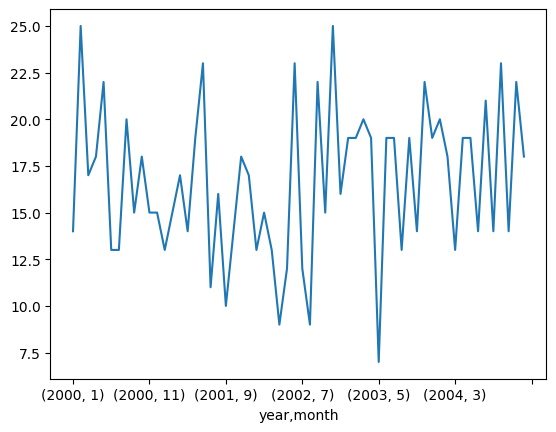

,name,type,n_calls,duration (msec)
0,datetime_extract,kernel,3,3.389348
1,to_datetime,kernel,1,3.123845
2,groupby_select_agg,kernel,1,1.217144
3,to_pandas.frame.metadata,kernel,1,0.369554
4,from_pandas.frame.metadata,kernel,1,0.136971
5,setitem,kernel,3,0.007070
6,getattr:plot,fallback,1,0.006160


In [ ]:
%%fireducks.profile
demo_cse(s, is_eager_mode = False)

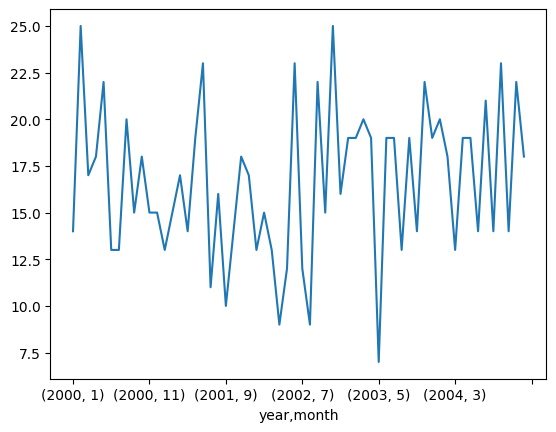

,name,type,n_calls,duration (msec)
0,to_datetime,kernel,3,7.066189
1,datetime_extract,kernel,3,4.024145
2,groupby_select_agg,kernel,1,1.412016
3,to_pandas.frame.metadata,kernel,1,0.689508
4,from_pandas.frame.metadata,kernel,1,0.248653
5,setitem,kernel,3,0.009400
6,getattr:plot,fallback,1,0.007130


In [ ]:
%%fireducks.profile
demo_cse(s, is_eager_mode = True)

### 2. Dead Code Elimination

In [ ]:
df1 = pd.DataFrame({"a": [1, 2, 3, 4], "b": [10, 11, 12, 13]})
df1

,a,b
0,1,10
1,2,11
2,3,12
3,4,13


In [ ]:
df2 = pd.DataFrame({"a": [4, 1, 3], "c": [0, 1, 0], "d": [40, 10, 30]})
df2

,a,c,d
0,4,0,40
1,1,1,10
2,3,0,30


In [ ]:
def demo_dce(df1, df2, is_eager_mode = False):
    from fireducks.core import get_fireducks_options
    get_fireducks_options().set_benchmark_mode(is_eager_mode)

    merged_df = df1.merge(df2, on="a")
    sorted_df = merged_df.sort_values(by="a")
    #print(sorted_df)
    return merged_df.groupby("c")["d"].sum()

In [ ]:
%%fireducks.profile
demo_dce(df1, df2, is_eager_mode = False)

c
0    70
1    10
Name: d, dtype: int64

,name,type,n_calls,duration (msec)
0,join,kernel,1,1.721599
1,to_pandas.frame.metadata,kernel,1,0.392294
2,Series.__repr__,fallback,1,0.172962
3,groupby_select_agg,kernel,1,0.089661
4,getattr:__repr__,fallback,1,0.003370
5,get_shape,kernel,1,0.000890


In [ ]:
%%fireducks.profile
demo_dce(df1, df2, is_eager_mode = True)

c
0    70
1    10
Name: d, dtype: int64

,name,type,n_calls,duration (msec)
0,sort_values,kernel,1,2.129054
1,join,kernel,1,1.563498
2,to_pandas.frame.metadata,kernel,1,0.501806
3,Series.__repr__,fallback,1,0.140652
4,groupby_select_agg,kernel,1,0.096081
5,getattr:__repr__,fallback,1,0.003040
6,get_shape,kernel,1,0.000320


### 3. IO optimization

In [ ]:
!wget https://data.rapids.ai/datasets/nyc_parking/nyc_parking_violations_2022.parquet

--2025-01-08 13:44:20--  https://data.rapids.ai/datasets/nyc_parking/nyc_parking_violations_2022.parquet
proxygate1.nic.nec.co.jp (proxygate1.nic.nec.co.jp) をDNSに問いあわせています... 10.51.8.101, 10.51.8.102
proxygate1.nic.nec.co.jp (proxygate1.nic.nec.co.jp)|10.51.8.101|:8080 に接続しています... 接続しました。
Proxy による接続要求を送信しました、応答を待っています... 200 OK
長さ: 474211285 (452M) [binary/octet-stream]
‘nyc_parking_violations_2022.parquet.8’ に保存中

nyc_parking_violati 100%[===================>] 452.24M  20.1MB/s    in 27s     

2025-01-08 13:44:49 (16.5 MB/s) - ‘nyc_parking_violations_2022.parquet.8’ へ保存完了 [474211285/474211285]



In [ ]:
def io_opt(is_eager_mode = False):
    from fireducks.core import get_fireducks_options
    get_fireducks_options().set_benchmark_mode(is_eager_mode)

    (
        pd.read_parquet("nyc_parking_violations_2022.parquet")
          .groupby("Vehicle Body Type")
          .agg(Count=("Summons Number", "count"))
          .sort_values(by="Count", ascending=False)
          .head(10)
          .plot(kind="bar")
    )

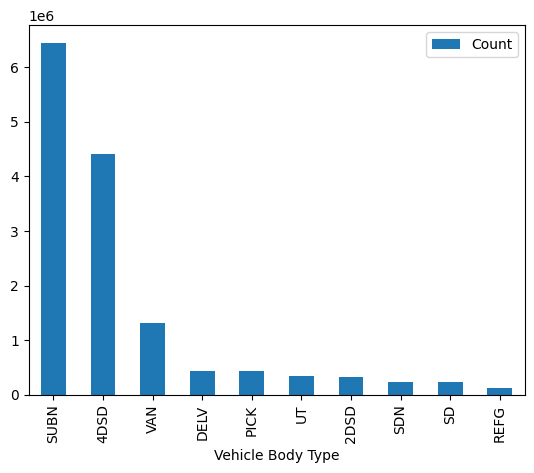

,name,type,n_calls,duration (msec)
0,read_parquet_with_metadata,kernel,1,323.419460
1,groupby_agg,kernel,1,19.939603
2,sort_values,kernel,1,5.934596
3,read_parquet_metadata,kernel,1,3.569719
4,to_pandas.frame.metadata,kernel,1,1.573358
5,getattr:plot,fallback,1,0.036241
6,slice,kernel,1,0.012800


In [ ]:
%%fireducks.profile
io_opt(is_eager_mode = False)

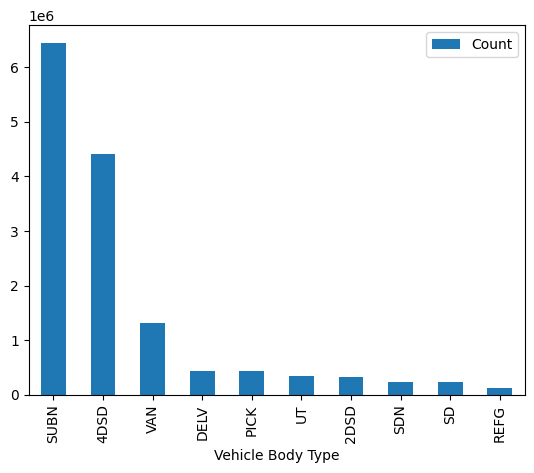

,name,type,n_calls,duration (msec)
0,read_parquet_with_metadata,kernel,1,953.225877
1,groupby_agg,kernel,1,13.031106
2,sort_values,kernel,1,4.773773
3,read_parquet_metadata,kernel,1,1.306474
4,to_pandas.frame.metadata,kernel,1,0.858830
5,getattr:plot,fallback,1,0.015830
6,project,kernel,1,0.012550
7,slice,kernel,1,0.012410


In [ ]:
%%fireducks.profile
io_opt(is_eager_mode = True)

### 4. Pushdown Projection

In [ ]:
def generate_random_data(size):
    df = pd.DataFrame()
    df["A"] = np.random.choice(range(2000, 2010), size)
    for e in list("BCDEFGHIJKLMNOP"):
        df[e] = np.random.randn(size)
    return df

df = generate_random_data(10 ** 6)
df

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P
0,2007,-0.072677,-1.596960,0.745587,1.508895,0.694224,-0.429874,-1.058868,-0.330583,-1.746814,0.051886,-0.355890,1.082854,0.446056,0.279910,0.360545
1,2009,0.626635,0.115284,2.622135,-0.355570,1.611203,0.065316,-0.402626,-1.742196,0.181408,-0.062681,0.228051,-0.523456,-0.266911,0.479098,0.579345
2,2001,-0.419023,-2.024544,-0.445462,-0.210488,-1.228251,-0.438826,0.914824,0.928477,-2.212586,0.240491,1.997828,1.372054,0.055943,-0.711808,1.048406
3,2008,-0.753279,-1.472693,0.444650,0.520123,-1.503761,-0.366025,-2.439646,-1.197867,-0.679259,0.500299,-0.009084,0.892733,-0.864724,0.399463,0.200197
4,2004,-0.106691,-0.111883,-1.270557,-0.101664,0.153593,-0.865585,0.276958,-0.879038,0.116102,-0.324998,1.225151,1.271126,0.579711,-0.589307,0.014252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,2008,0.272680,-0.547530,1.138216,0.135116,-0.055627,0.335748,-0.434452,0.360104,1.519035,1.267445,0.661670,-0.335957,-0.025507,-2.041482,0.742760
999996,2003,-1.326835,1.628809,-0.418786,0.207632,-1.113079,0.801642,-0.297992,-0.230202,-0.831293,-0.155903,0.960424,-0.197980,1.825126,0.057595,-0.869767
999997,2002,-1.294700,0.365997,-0.631927,-0.602167,0.946146,0.354020,1.375709,-0.656847,-1.279826,-0.776714,-0.118042,-1.143189,-0.027560,0.488546,-0.075595
999998,2008,-0.567128,0.842108,-0.014017,-1.904270,-1.797044,0.351553,-0.080160,-1.191733,-1.422979,0.550327,-0.315597,0.458799,0.598073,0.332689,-0.644473


In [ ]:
def demo_pushdown_projection(df, is_eager_mode = False):
    from fireducks.core import get_fireducks_options
    get_fireducks_options().set_benchmark_mode(is_eager_mode)

    res = df.groupby("A").sum()[["B", "C"]]
    print(res)

In [ ]:
%%fireducks.profile
demo_pushdown_projection(df, is_eager_mode = False)

               B           C
A                           
2000  636.260726 -119.329944
2001 -287.418806  166.344993
2002 -108.489035   45.700860
2003  489.489007  -24.470316
2004   74.299286 -273.948584
2005  -68.709634   80.408973
2006  269.193453   -5.237901
2007  470.580818   17.016405
2008 -614.801753 -453.329569
2009 -261.078896    0.367935


,name,type,n_calls,duration (msec)
0,groupby_agg,kernel,1,3.780583
1,DataFrame.__repr__,fallback,1,2.214825
2,to_pandas.frame.metadata,kernel,1,1.926742
3,project,kernel,2,0.010190
4,getattr:__repr__,fallback,1,0.003130
5,get_shape,kernel,1,0.002540


In [ ]:
%%fireducks.profile
demo_pushdown_projection(df, is_eager_mode = True)

               B           C
A                           
2000  636.260726 -119.329944
2001 -287.418806  166.344993
2002 -108.489035   45.700860
2003  489.489007  -24.470316
2004   74.299286 -273.948584
2005  -68.709634   80.408973
2006  269.193453   -5.237901
2007  470.580818   17.016405
2008 -614.801753 -453.329569
2009 -261.078896    0.367935


,name,type,n_calls,duration (msec)
0,groupby_agg,kernel,1,11.565220
1,DataFrame.__repr__,fallback,1,1.219704
2,to_pandas.frame.metadata,kernel,1,1.200374
3,project,kernel,1,0.005060
4,getattr:__repr__,fallback,1,0.003930
5,get_shape,kernel,1,0.000400


### 5. Predicate Projection

In [ ]:
def demo_predicate_pushdown(df, is_eager_mode = False):
    from fireducks.core import get_fireducks_options
    get_fireducks_options().set_benchmark_mode(is_eager_mode)

    res = df.sort_values(by="B").pipe(lambda df: df[(df["A"] > 2005) & (df["A"] < 2008)])
    print(res)

In [ ]:
%%fireducks.profile
demo_predicate_pushdown(df, is_eager_mode = False)

           A         B         C         D         E         F         G  \
740798  2007 -4.499804  0.073802  0.794763  0.571575  0.493793 -1.908167   
936188  2006 -4.412715  1.026171 -0.337072 -0.217573  0.089585 -0.307275   
341209  2007 -4.192614  0.114829  0.641555  0.615326  0.488293 -1.583569   
869169  2007 -4.166337 -0.210371  0.863194  1.171357  1.438408  0.026189   
826125  2006 -4.062738 -1.936141  0.753181  0.585812 -0.756294  0.572740   
...      ...       ...       ...       ...       ...       ...       ...   
964739  2006  3.893442  1.983628  0.194492  0.662519 -1.477432 -0.462078   
743420  2006  3.895418  0.787685  0.219590 -1.290643 -1.882074 -0.230526   
758849  2006  3.952089  1.412559  1.637176 -0.295840  0.097795 -1.039417   
930196  2006  4.038731 -0.011697  1.809036  2.406499  2.599900  1.806853   
902023  2007  4.559371  0.843798  0.581792  0.446892 -0.509769  1.080023   

               H         I         J         K         L         M         N  \
740798 

,name,type,n_calls,duration (msec)
0,sort_values,kernel,1,209.596285
1,filter,kernel,1,20.317437
2,DataFrame.__repr__,fallback,1,9.617188
3,lt.vector.scalar,kernel,1,8.116611
4,gt.vector.scalar,kernel,1,6.145829
5,and.vector.vector,kernel,1,6.065267
6,to_pandas.frame.metadata,kernel,1,1.480207
7,slice,kernel,2,0.084741
8,concat,kernel,1,0.045331
9,getattr:__repr__,fallback,1,0.008140


In [ ]:
%%fireducks.profile
demo_predicate_pushdown(df, is_eager_mode = True)

           A         B         C         D         E         F         G  \
740798  2007 -4.499804  0.073802  0.794763  0.571575  0.493793 -1.908167   
936188  2006 -4.412715  1.026171 -0.337072 -0.217573  0.089585 -0.307275   
341209  2007 -4.192614  0.114829  0.641555  0.615326  0.488293 -1.583569   
869169  2007 -4.166337 -0.210371  0.863194  1.171357  1.438408  0.026189   
826125  2006 -4.062738 -1.936141  0.753181  0.585812 -0.756294  0.572740   
...      ...       ...       ...       ...       ...       ...       ...   
964739  2006  3.893442  1.983628  0.194492  0.662519 -1.477432 -0.462078   
743420  2006  3.895418  0.787685  0.219590 -1.290643 -1.882074 -0.230526   
758849  2006  3.952089  1.412559  1.637176 -0.295840  0.097795 -1.039417   
930196  2006  4.038731 -0.011697  1.809036  2.406499  2.599900  1.806853   
902023  2007  4.559371  0.843798  0.581792  0.446892 -0.509769  1.080023   

               H         I         J         K         L         M         N  \
740798 

,name,type,n_calls,duration (msec)
0,sort_values,kernel,1,80.317858
1,filter,kernel,1,17.310394
2,DataFrame.__repr__,fallback,1,7.023559
3,to_pandas.frame.metadata,kernel,1,1.276964
4,gt.vector.scalar,kernel,1,1.019981
5,lt.vector.scalar,kernel,1,0.921200
6,and.vector.vector,kernel,1,0.865390
7,slice,kernel,2,0.090221
8,concat,kernel,1,0.029940
9,project,kernel,2,0.014840
